In [1]:
#connect from Mongo DB and import it on pandas
from pymongo import MongoClient
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
import matplotlib.pyplot as plt



In [2]:
client = MongoClient("localhost", 27017)
db = client["IF29"]
collec = db.user_db #whole database
#collec = db.user_db_sample #small db with 100 tweets
data_db = pd.DataFrame(list(collec.find()))
data = data_db.sample(frac=0.01, random_state=42)
max_date = data.created_date.max()
data["diff"] = data.created_date.apply(lambda x : (x - max_date).seconds)


#choose feature
features = ["verified","protected","friend_nb","listed_nb","follower_nb","favorites_nb","len_description","hash_avg","mention_avg","url_avg","symbols_avg","tweet_nb","tweet_user_count","user_lifetime","tweet_frequency","friend_frequency","aggressivity","visibility","ff_ratio"]
X = data[features]
debug = ["url_bool","retweet_avg"] #attribute to debug on file 2.user_db.py

In [3]:
# Normalisation des données
#normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_normalized = scaler.fit_transform(X)


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

# Fonction pour calculer le score de silhouette pour un k donné
def compute_silhouette_score(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42,  n_init='auto')
    kmeans.fit(data)
    labels = kmeans.labels_
    return silhouette_score(data, labels)



In [5]:
# Calculer les scores de silhouette en parallèle pour k variant de 2 à 10
silhouette_scores = Parallel(n_jobs=-1)(delayed(compute_silhouette_score)(k, data_normalized) for k in range(2, 11))

# Afficher les scores de silhouette
print("Silhouette Scores for each k:", silhouette_scores)

Silhouette Scores for each k: [0.8583474358772536, 0.3154628040257345, 0.170334558037337, 0.17659197147158617, 0.1775594260629908, 0.16889595495931303, 0.15496606046034314, 0.16352195693177568, 0.16359188146296086]


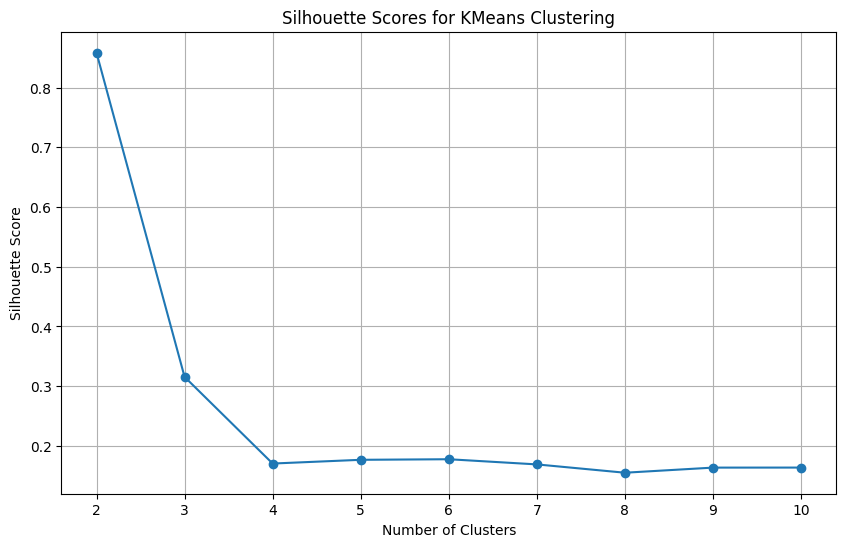

In [6]:
# Tracer les scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Scores for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [7]:
# Implémenter la méthode du coude
def find_elbow_point(silhouette_scores):
    deltas = np.diff(silhouette_scores)
    delta_deltas = np.diff(deltas)
    return np.argmax(delta_deltas) + 2  # +2 pour compenser les différences successives

optimal_k = find_elbow_point(silhouette_scores)
print(f"Optimal number of clusters according to the elbow method: {optimal_k}")


Optimal number of clusters according to the elbow method: 2


In [8]:
# Appliquer KMeans avec le nombre optimal de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(data_normalized)
labels_optimal = kmeans_optimal.labels_


C:\Users\julie\AppData\Local\Temp\ipykernel_15492\3881888308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = labels_optimal


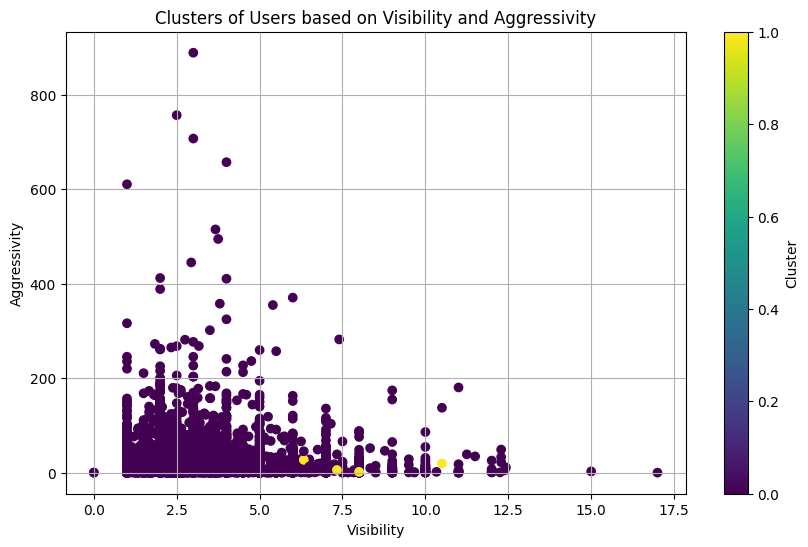

In [9]:

# Ajouter les labels aux données
X['cluster'] = labels_optimal

# Afficher les données avec les clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['visibility'], X['aggressivity'], c=X['cluster'], cmap='viridis')
plt.title("Clusters of Users based on Visibility and Aggressivity")
plt.xlabel("Visibility")
plt.ylabel("Aggressivity")
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

In [10]:
cluster_describe = X.groupby('cluster').describe()
print(cluster_describe)

        verified                                              protected       \
           count      mean       std  min  25%  50%  75%  max     count mean   
cluster                                                                        
0        18417.0  0.010805  0.103388  0.0  0.0  0.0  0.0  1.0   18417.0  0.0   
1           17.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0      17.0  0.0   

         ... visibility       ff_ratio                                      \
         ...        75%   max    count      mean        std  min       25%   
cluster  ...                                                                 
0        ...   3.000000  17.0  18417.0  2.974497   7.908662  0.0  0.695652   
1        ...   6.333333  10.5     17.0  6.690917  17.170828  0.0  0.261406   

                                    
              50%       75%    max  
cluster                             
0        1.195767  2.696095  285.5  
1        1.218688  1.836735   67.0  

[2 rows x 152 columns]

In [11]:
# Enregistrer le DataFrame en fichier CSV
cluster_describe.to_csv('kmeans_describe.csv')